# Introduction

Text classification is one of the most common tasks in NLP; it can be used for a broad range of applications, such as tagging customer feedback into categories or routing support tickets according to their language.

In this tutorial was used a variant of BERT called [DistilBERT](https://arxiv.org/abs/1910.01108) V. Sanh et al., "DistilBERT, a Distilled Version of BERT: Smaller, Faster, Cheaper and Lighter", (2019).

Notice that I'm following the book: *[Natural language processing with transformers](https://books.google.pt/books?hl=en&lr=&id=nzxbEAAAQBAJ&oi=fnd&pg=PP1&dq=natural+language+processing+with+hugging+face+book&ots=sUngJ_q1JE&sig=jA559R-MigxWmh5vZQtpTJSeJkU&redir_esc=y#v=onepage&q=natural%20language%20processing%20with%20hugging%20face%20book&f=false)*.

# Instalations

In [ ]:
! pip install 'transformers[torch]'

In [ ]:
! pip install datasets

In [ ]:
! pip install scikit-learn

In [ ]:
! pip install huggingface_hub

In [ ]:
! pip install pandas

In [ ]:
! pip install matplotlib

In [ ]:
! pip install torch

In [ ]:
! pip install umap-learn

# Dataset

Load datasets from Hugging Face hub

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

/var/folders/6z/wyz90bzs7d3d4qtz9gpr_vg00000gn/T/ipykernel_8408/89111038.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 86869 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


#### or

In [4]:
import huggingface_hub

all_datasets_generator = huggingface_hub.list_datasets()
all_datasets_list = list(all_datasets_generator)

print(f"There are {len(all_datasets_list)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets_list[:10]}")

There are 86868 datasets currently available on the Hub
The first 10 are: [DatasetInfo(id='acronym_identification', author=None, sha='c3c245a18bbd57b1682b099e14460eebf154cbdf', last_modified=datetime.datetime(2023, 1, 25, 14, 18, 28, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=1167, likes=17, paperswithcode_id='acronym-identification', tags=['task_categories:token-classification', 'annotations_creators:expert-generated', 'language_creators:found', 'multilinguality:monolingual', 'size_categories:10K<n<100K', 'source_datasets:original', 'language:en', 'license:mit', 'acronym-identification', 'arxiv:2010.14678', 'region:us'], card_data=None, siblings=None), DatasetInfo(id='ade_corpus_v2', author=None, sha='080cf99e1483008322d612c7262c04c8902fdbee', last_modified=datetime.datetime(2023, 6, 1, 13, 59, 53, tzinfo=datetime.timezone.utc), private=False, gated=False, disabled=False, downloads=1647, likes=20, paperswithcode_id=None, tags=['task_categories

In [5]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


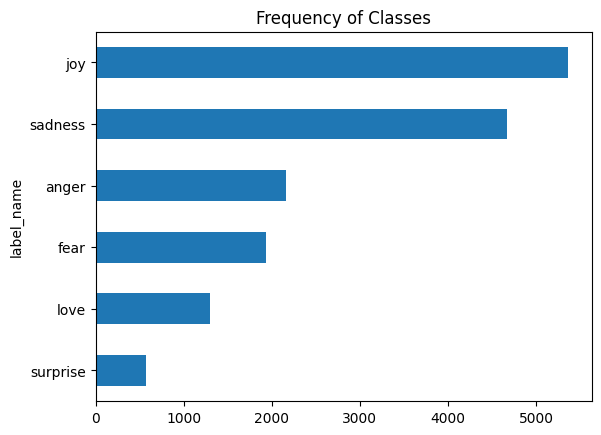

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

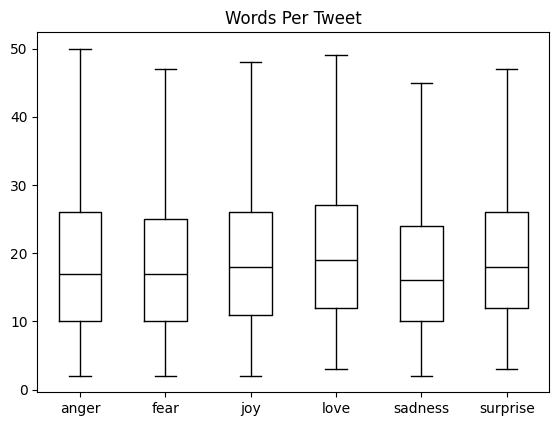

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [15]:
emotions.reset_format()

# Tokens

In [17]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
encoded_text = tokenizer(text)
print(encoded_text)
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
print(tokenizer.convert_tokens_to_string(tokens))

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
[CLS] tokenizing text is a core task of nlp. [SEP]


In [19]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [20]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


# hide_output
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Training a Text Classifier

## Transformers as Feature Extractors

In [24]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [25]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

print(emotions_hidden)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})


In [26]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [28]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


,X,Y,label
0,4.148213,6.415390,0
1,-3.159162,5.731359,0
2,5.136327,3.030874,3
3,-2.782178,3.679936,2
4,-3.577852,3.803342,3


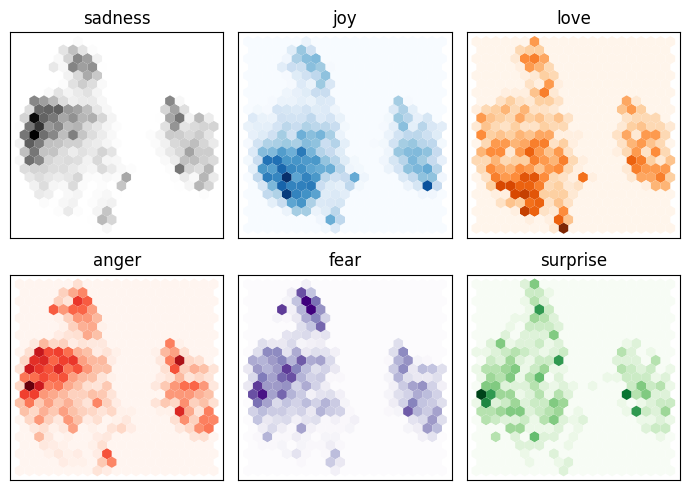

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [33]:
lr_clf.score(X_valid, y_valid)

0.633

In [34]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

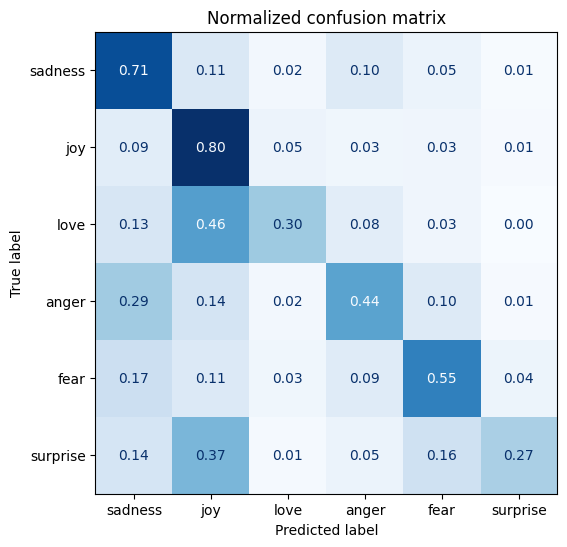

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# Reference

1. Tunstall, Lewis and Von Werra, Leandro and Wolf, Thomas. (2022). *[Natural language processing with transformers](https://books.google.pt/books?hl=en&lr=&id=nzxbEAAAQBAJ&oi=fnd&pg=PP1&dq=natural+language+processing+with+hugging+face+book&ots=sUngJ_q1JE&sig=jA559R-MigxWmh5vZQtpTJSeJkU&redir_esc=y#v=onepage&q=natural%20language%20processing%20with%20hugging%20face%20book&f=false)*. O'Reilly Media, Inc.

## Additional Resources

- [Hugging Face Official Documentation](https://huggingface.co/docs)
- [Hugging Face Model Hub](https://huggingface.co/models)